# Library

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random
import csv

# DDQN

In [17]:
class DoubleDeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2000)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.model_target = self.build_model() #Second (target) neural network
        self.update_target_from_model() #Update weights
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(32, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(1024, activation='relu', kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.L1(0.0), activity_regularizer=tf.keras.regularizers.L2(0.1)))
        model.add(keras.layers.Dense(1024, activation='relu', kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.L1(0.0), activity_regularizer=tf.keras.regularizers.L2(0.1)))
        model.add(keras.layers.Dense(1024, activation='relu', kernel_initializer='ones', kernel_regularizer=tf.keras.regularizers.L1(0.0), activity_regularizer=tf.keras.regularizers.L2(0.1)))
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def update_target_from_model(self):
        #Update the target model from the base model
        self.model_target.set_weights( self.model.get_weights() )

    def action(self, env, state):
        A = np.random.random()
        if A <= self.epsilon:
          action = env.sam_action() #Explore
          return action
        else:        
          action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
          act_idx = np.argmax(action_vals[0])
          action = env.index2action(act_idx)
          return action
        

    def test_action(self, env,state): #Exploit
        action_vals = self.model.predict(state)
        act_idx = np.argmax(action_vals[0])
        action = env.index2action(act_idx)
        return action 

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, env, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0) # Because the store includes state, action, reward, nstate, and done
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        #print(f"st_predict:{st_predict}")
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst) #Predict from the TARGET
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Using Q to get T is Double DQN

            #print(f"target:{target}") 
            target_f = st_predict[index]
            #print(f"target_f:{target_f}")  
            #print(f"size target_f:{target_f.shape}") 
            idx = env.action2index(action)
            #print(f"idx:{int(idx)}") 
            #print(f"target_f[2]:{target_f[2]}") 
            target_f[int(idx)] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return self.epsilon

# Environment

In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import os

class Helper:
    def __init__(self, rc, max_f, max_c):
        """
        Initial Method for Continuous Environment
        params - rc: float - Radius Cycle
        params - max_f: float - Maximum CPUs
        params - max_c: float - Maximum Costs
        """
        if rc < 0 or max_f < 0 or max_c < 0:
            raise Exception(
                    "Initial Values for Helper must be Positive!"
                )
        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c

        self.f = None
        self.c = None

    def become_stranger(self):
        """This node become to a Stranger Node"""
        f_frac = np.random.uniform(low=1e-6, high=1e-5)
        c_frac = np.random.uniform(low=0.08, high=0.01)
        self.f = self.f * f_frac
        self.c = self.c * c_frac

        if np.random.rand() < 0.9:
            self.c = self.c  * f_frac * np.random.uniform(low=10.0, high=20.0)
        else:
            self.c = self.c * f_frac

    def reset(self):
        """
        Create a New Instance
        """
        self.f = np.random.normal(loc=self.max_f * 0.5, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.max_c * 0.5, scale=self.max_c * 1e-4)

        # if np.random.rand() < 0.1:
        #     self.become_stranger()

        if self.f < 0:
            self.f = self.max_f * 0.5
        if self.c < 0:
            self.c = self.max_c * 0.5

    def transit(self):
        """
        Move to a Next State
        """
        self.f = np.random.normal(loc=self.f, scale=self.max_f * 1e-4)
        self.c = np.random.normal(loc=self.c, scale=self.max_c * 1e-4)

        if self.f < 0:
            self.f = self.max_f * 0.5

        if self.c < 0:
            self.c = self.max_c * 0.5

        # if np.random.rand() < 0.1:
        #     self.become_stranger()

    def cal_com_latency(self, num_bytes):
        """
        Calculate The Latency for Computing "num_bytes" data 
        params: num_bytes - Integer - Computation Demand
        """
        num_bytes = float(num_bytes)
        latency = num_bytes / self.f
        return latency

    def cal_offload_latency(self, num_bytes, mu, m, d_n):
        """
        Calculate The Latency for Offloading "num_bytes" data
        params: num_bytes - Integer - Offloading Demand
        """
        num_bytes = float(num_bytes)
        # Transformation Parameters
        CO = 3*1e8
        Fc = 1e4
        BW = 10e7
        G_RA = 1.8
        P_max = 250*10**(-3)
        Loss_free = (4*np.pi* Fc * d_n/CO)**2
        sigma_2 = 4*10**(-21)

        pr = (mu*P_max*(G_RA)**2)/Loss_free
        SNR = m*pr/(BW*sigma_2)
        rn = (BW/m) * np.log2(1.0 + SNR) 
        latency = num_bytes / rn
        return latency

    def cal_incentive_cost(self, num_bytes):
        """
        Calculate the Incentive Cost for Processing "num_bytes" data
        params: - num_bytes : Integer
        """
        cost = self.c * self.cal_com_latency(num_bytes)
        return cost

    def show_cur_state(self):
        print("d: {:.3f}, f: {:.3f}, c: {:.10f}".format(self.d, self.f, self.c))

    def get_state(self):
        """
        Get the Current State of This Helper
        """
        state = [self.f/self.max_f, self.c/self.max_c]

        return state

class TaskOffloadEnv:
    def __init__(self, n_helpers, rc, max_f, max_c, max_l, alpha1, alpha2, alpha3, alpha4, v_min, v_max,  seed):
        """
        Initial Method for Task Offload Environments
        """
        self.n_helpers = n_helpers

        self.rc = rc
        self.max_f = max_f
        self.max_c = max_c
        self.max_l = max_l

        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.alpha3 = alpha3
        self.alpha4 = alpha4
        self.helpers = {}
        self.step_counter = 0

        self.v_min = v_min
        self.v_max = v_max

        self.curr_n_helpers = self.n_helpers

        # environment's configuration
        self.act_dims = [self.n_helpers] + [2 for _ in range(self.n_helpers)] + [2] 
        self.num_actions = self.n_helpers * (2 ** self.n_helpers) * 2
        self.env_dims = 2 + self.n_helpers * 6

        # Client initialization
        self.x_0 = 0
        self.y_0 = 0
        self.v_x = 0
        self.v_y = 0

        self.userList_x = []
        self.userList_y = []
        self.userList_location = []
        
        self.userList_velocity_x = []
        self.userList_velocity_y = []
        self.userList_velocity = []

        self.d_n = 0

        np.random.seed(seed)

    def _clientInit(self, ):
      for user_no in range(self.n_helpers):
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x1 = self.x_0 + user_Radius * math.cos(user_Angle)
        user_x2 = self.x_0 - user_Radius * math.cos(user_Angle)
        user_x = random.choice([user_x1, user_x2])
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        self.userList_x.append(user_x)
        self.userList_y.append(user_y)
        self.userList_location.append([user_x, user_y])
        self.userList_velocity.append([user_vx, user_vy])

      # # Client Plot
      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # print(f"List of user location is: {self.userList_location}")
      # print(f"List of user velocity is: {self.userList_velocity}")
      # plt.scatter(self.userList_x, self.userList_y)
      # plt.show()
    
    def distance(self):
      userList_distance = []            
      # init client location:               
      client_location = (self.x_0, self.y_0)
      for user_no in range(self.n_helpers):
        #print(f"user_no {user_no}")
        user_distance = np.linalg.norm(np.array(self.userList_location[user_no]) - np.array(client_location))
        userList_distance.append(user_distance)
      #print(f"List of user distance is: {userList_distance}")
      return userList_distance

    def get_state(self):
        """
        Get Environment State
        """
        
        client_state = [self.l*1.0/self.max_l]
        helper_state = []
        userList_distance = self.distance()
        num_helpers = 0
        for key in sorted(list(self.helpers.keys())):                    
          if userList_distance[key] > self.rc:
            state_f_c = [0,0]
          else:
            helper = self.helpers[key]
            state_f_c = helper.get_state()
            num_helpers = num_helpers + 1
          location = self.userList_location[key]
          x = location[0]/self.rc
          y = location[1]/self.rc
          position = [x,y]
          velocity = self.userList_velocity[key]
          v_x = velocity[0]/self.v_max
          v_y = velocity[1]/self.v_max
          v= [v_x, v_y]
          state = position + v + state_f_c
          helper_state += state
          
        env_state = [num_helpers] + client_state + helper_state
        #print(f"env_state : {env_state}")
        return env_state

    def reset(self):
        """
        Create a New Instance
        """
        self._clientInit()
        self.l = np.random.normal(loc=self.max_l * 0.5, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5
        self.step_counter = 0
        for idx in range(self.n_helpers):
            self.helpers[idx] = Helper(self.rc, self.max_f, self.max_c)
            self.helpers[idx].reset()            
        self.client_f = self.max_f * np.random.normal(loc=0.0001, scale= 1e-6)

        state = self.get_state()
        #print(f"List of user state is: {state}")
        return state

    def Markov_chain(self,num_n_vehicles):

      n_vehicle_state = {0 : "N1",1 : "N2",2 : "N3", 3 : "N4", 4 : "N5"}
      State_1 = [0.4, 0.5, 0.05, 0.05, 0]
      State_2 = [0.3, 0.2, 0.3, 0.1, 0.1]
      State_3 = [0, 0.3, 0.3, 0.4, 0]
      State_4 = [0.05, 0.05, 0.3, 0.3, 0.3]
      State_5 = [0, 0.1, 0.2, 0.3, 0.4]
      transitionMatrix = np.array([State_1, State_2, State_3, State_4, State_5])
      activityList = []
      start_n_vehicles = num_n_vehicles - 1 
      next_n_vehicles = np.random.choice([0,1,2,3,4], p = transitionMatrix[start_n_vehicles])
      return next_n_vehicles + 1

    def transmit(self, curr_n_vehicles):
      # x = x + v_x*t, y = y + v_y*t
      y_vecto = []
      over_n_vehicles = 0
      index = []
      for user_no in range(self.n_helpers):
        self.userList_location[user_no][0] = self.userList_location[user_no][0] + self.userList_velocity[user_no][0]
        self.userList_location[user_no][1] = self.userList_location[user_no][1] + self.userList_velocity[user_no][1]

      userList_distance = self.distance()
      for user_no in range(self.n_helpers):
        if userList_distance[user_no] > self.rc:
          over_n_vehicles += 1
          index.append(user_no)
      remain_n_vehicles = curr_n_vehicles - over_n_vehicles

      next_n_vehicles = self.Markov_chain(remain_n_vehicles)

      if next_n_vehicles > remain_n_vehicles:
        add_num = next_n_vehicles - remain_n_vehicles
        #print(f"add_num: {add_num}")
        for i in range(add_num):
            idx = index[i]
            self.userList_location[idx], self.userList_velocity[idx] = self.out_of_range(add_num) 
        curr_n_vehicles = next_n_vehicles

      else:
        curr_n_vehicles = remain_n_vehicles     
      #print(f"curr_n_vehicles is: {curr_n_vehicles}")
      for key in self.helpers.keys():
        self.helpers[key].transit()

      # fig, ax = plt.subplots()                                                
      # circle1 = plt.Circle((self.x_0, self.y_0), self.rc, color='b', fill=False) 
      # circle2 = plt.Circle((self.x_0, self.y_0), 1, color='r', fill=True)       
      # ax.add_patch(circle1)
      # ax.add_patch(circle2)
      # userList_x,userList_y = [],[]
      # for user_no in range(self.n_helpers):
      #   x = self.userList_location[user_no][0]
      #   y= self.userList_location[user_no][1]
      #   userList_x.append(x)
      #   userList_y.append(y)
      # plt.scatter(userList_x, userList_y)
      # plt.show()
    
    def out_of_range(self, num):
      # When vehicles go through the circle
        user_Radius = random.uniform(self.rc/2, self.rc)
        line = [1,3]
        line = random.choice(line)
        if line == 1:
          user_Angle  = math.asin(self.rc/2/user_Radius)
        # elif line == 2:
        #   user_Angle  = math.asin(0/user_Radius)
        else:
          user_Angle  = math.asin(-self.rc/2/user_Radius)

        user_x = self.x_0 - user_Radius * math.cos(user_Angle)
        user_y = self.y_0 + user_Radius * math.sin(user_Angle)

        # velocity
        user_vy= 0
        user_vx = random.uniform(self.v_min , self.v_max)
        location = [user_x, user_y]
        velocity = [user_vx, user_vy]
        return location, velocity


    def step(self, action):
        """
        Perform an action
        action's format [k, a1, ..., aN, B_c]

        """
        done = False
        c0 = 3*10**8
        P_max = 250*10**(-3)
        G_RA = 1.8
        sigma_c = 100
        P_ra_min = 10**(-13)
        Lambda = 0.1
        f_rad = 76*10**9

        k = action[0]
        if action[-1] == 1:
          Power = 0.7
        else:
          Power = 0.9
        mu = Power
        a_vec = action[-self.n_helpers-1:-1]
        m = sum(a_vec)
        standard_time = self.l / self.client_f      
        com_fee, total_latency, required_connect = [], [], []
        num_bytes = self.l / k
        userList_distance = self.distance()
        for idx in sorted(list(self.helpers.keys())):
            if a_vec[idx] == 0:
                total_latency.append(np.Inf)
                com_fee.append(0.0)
                required_connect.append(0.0)
            else:
                helper = self.helpers[idx]
                d_n = userList_distance[idx]
                offload_latency = helper.cal_offload_latency(num_bytes, mu, m, d_n)
                com_latency = helper.cal_com_latency(num_bytes)
                fee = helper.cal_incentive_cost(num_bytes)
                com_fee.append(fee)
                total_n = offload_latency + com_latency
                total_latency.append(total_n)
                duration = self.constrain(self.rc, self.userList_velocity[idx][0], 0 , d_n, 0)
                if total_n <= duration:
                  rw_link =  Lambda
                else:
                  rw_link = 0
                required_connect.append(rw_link)

        total_latency = sorted(total_latency)
        required_latency = max(total_latency[:k])
        required_fee = np.sum(com_fee)
        connect_rw = np.sum(required_connect)
        lamda_rad = c0/f_rad
        res_max = (P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        res = ((1-mu)*P_max*(G_RA)**2*lamda_rad**2*sigma_c/(4*(np.pi)**2*P_ra_min))**(1/4)
        rw_anten =  res/res_max
        required_anten =  rw_anten
        done = False
        # Calculate in Case the action meets the conditions
        if k <= m:
            if required_latency > standard_time:
                com_reward = -standard_time
            else:
                com_reward = standard_time - required_latency
            com_reward = com_reward * self.alpha1
            cost_reward = required_fee * self.alpha2
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        else:
            """
            an action doesn't meet the conditions
            """
            com_reward = -1.0 * self.alpha1 * standard_time
            cost_reward = 1.0 * self.alpha2 * required_fee
            if m == 0:
                cost_reward = (self.l / self.client_f) * self.max_c
            anten_reward =  required_anten*self.alpha3
            connect_reward = connect_rw*self.alpha4
            total_reward = com_reward - cost_reward + anten_reward + connect_reward
        reward = [total_reward, com_reward, cost_reward, anten_reward, connect_reward]
        
        """
        Move to the next State
        """
        self.l = np.random.normal(loc=self.l, scale=self.max_l * 1e-6)
        if self.l < 0:
            self.l = self.max_l * 0.5

        self. transmit(self.curr_n_helpers)
        next_state = self.get_state()
        return next_state, reward, done

    def sam_action(self):
        """
        select one action randomly
        action's format [k, a1, ..., aN]
        """
        k = random.randint(1, self.n_helpers)
        if k==1:
          x=1
        else:
          x=k//1.5
        n = random.randint(x, self.n_helpers)
        # mylist = [0.7, 0.9]
        # Power = []
        # for i in range(len(mylist)):
        #   if mylist[i]==0.7:
        #     pw = 1
        #   else:
        #     pw = 2
        #   Power.append(pw)

        # mu = random.choice(Power)
        mu=random.choice([1, 2])
        a_vec = [0.0 for _ in range(self.n_helpers)]
        sel_helper_idxs = np.random.permutation(self.n_helpers)[0:n]
        for helper_idx in list(sel_helper_idxs):
            a_vec[helper_idx] = 1.0
        action = [k] + a_vec + [mu]
        return action

    def constrain(self, D, v_n, v_t, z_n, z_t):
      duration = D/(v_n-v_t) - (z_n - z_t)/(v_n-v_t)
      return duration

    def action2index(self, action):
        """
        Convert action from nulti-dimension format to index format
        """
        if len(action) != len(self.act_dims):
            raise Exception("Shape Error")
        
        act_idx = action[0] - 1
        for i in range(1, len(self.act_dims)-1):
            act_idx = act_idx * self.act_dims[i] + action[i]
        act_idx = act_idx * 2 + (action[-1] - 1)
        return act_idx

    def index2action(self, act_idx):
        """
        Convert action from index format to multi-dimension format
        """
        action = []
        action_bw = act_idx % 2
        act_idx = (act_idx - action_bw)/2
        #action_bw = action_bw + 1
        for i in range(len(self.act_dims)-1, 1, -1):
            ai = act_idx % self.act_dims[i-1]
            action.append(int(ai))
            act_idx = (act_idx - ai) / self.act_dims[i-1]
        
        action.append(int(act_idx))
        action = [action_bw+ 1] + action
        action.reverse()
        action[0] = action[0] + 1
        return action

if __name__ == "__main__":
    env = TaskOffloadEnv(n_helpers=5,rc=100,max_f=100,max_c=100,max_l=100,alpha1=1.0,alpha2=1.0,alpha3=1.0,alpha4=1.0, v_min=0,v_max=50,seed=1)
    action = env.sam_action()
    idx = env.action2index(action)
    recovered = env.index2action(idx)
    print(idx)
    print(action, recovered)


8.0
[1, 0.0, 0.0, 1.0, 0.0, 0.0, 1] [1, 0, 0, 1, 0, 0, 1.0]


# Parameters

In [19]:
n_helpers = 5
rc = 100.0
max_f = 2e9
max_c = 1e2
max_l = 3e5*8
alpha1 = 2
alpha2 = 2.0
alpha3 = 5
alpha4 = 5
BW = 10e7
seed = 1
v_min = 0
v_max = 10
num_episodes = 100
max_step_per_episode = 500
buffer_size = 2000
batch_size = 32
max_eps = 1.0
epsilon = max_eps
min_eps = 0.1
gpu_idx = -1
log_dir = "../log"

CHECKPOINT = 20

#Main

In [20]:
gamma = 0.99
epsilon_decay = 0.9999
env = TaskOffloadEnv(n_helpers,rc,max_f,max_c,max_l,alpha1,alpha2,alpha3, alpha4, v_min, v_max, seed)
nS = env.env_dims
print(nS)
nA = env.num_actions
print(nA)
learning_rate = 1e-3
discount_rate = gamma
dqn = DoubleDeepQNetwork(nS, nA, learning_rate, discount_rate, epsilon, min_eps, epsilon_decay)
log_total_reward_ddqn, log_comp_reward_ddqn, log_cost_reward_ddqn, log_anten_reward_ddqn, log_connect_reward_ddqn = [], [], [], [], []
epsilon = max_eps
frame_count = 0
for episode in range(num_episodes):
	state = env.reset()
	state = np.reshape(state, [1, nS])
	for step in range(max_step_per_episode):
		frame_count +=1
		action = dqn.action(env, state)
		nstate, reward, done = env.step(action)
		nstate = np.reshape(nstate, [1, nS])

		dqn.store(state, action, reward[0], nstate, done) # Resize to store in memory to pass to .predict
		state = nstate

		#Experience Replay
		if len(dqn.memory) > batch_size:
			epsilon = dqn.experience_replay(env, batch_size)
    #Update the weights after each episode (You can configure this for x steps as well
		epsilon = max(epsilon,min_eps)
	
		''' 
			Average & Print
		'''
		if ((step) % CHECKPOINT >= 0) and ((step) % CHECKPOINT <= CHECKPOINT - 1):
			if (step) % CHECKPOINT == 0:
				list_total_ddqn, list_comp_ddqn, list_cost_ddqn, list_anten_ddqn, list_connect_ddqn = [], [], [], [], []

				total_reward_ddqn, comp_reward_ddqn, cost_reward_ddqn, anten_reward_ddqn, connect_reward_ddqn = 0, 0, 0, 0, 0

			total_reward_ddqn = reward[0]
			comp_reward_ddqn = reward[1] 
			cost_reward_ddqn = reward[2] 
			anten_reward_ddqn = reward[3] 
			connect_reward_ddqn = reward[4]
			list_total_ddqn.append(total_reward_ddqn)
			list_comp_ddqn.append(comp_reward_ddqn)
			list_cost_ddqn.append(cost_reward_ddqn)
			list_anten_ddqn.append(anten_reward_ddqn)
			list_connect_ddqn.append(connect_reward_ddqn)

			if (step) % CHECKPOINT == CHECKPOINT - 1:		
				avg_total_ddqn = np.mean(list_total_ddqn)
				avg_comp_ddqn = np.mean(list_comp_ddqn)
				avg_anten_ddqn = np.mean(list_anten_ddqn)
				avg_cost_ddqn = np.mean(list_cost_ddqn)
				avg_connect_ddqn = np.mean(list_connect_ddqn)
					
				log_total_reward_ddqn.append(avg_total_ddqn)
				log_comp_reward_ddqn.append(avg_comp_ddqn)
				log_cost_reward_ddqn.append(avg_cost_ddqn)
				log_anten_reward_ddqn.append(avg_anten_ddqn)
				log_connect_reward_ddqn.append(avg_connect_ddqn)
			if (step) % CHECKPOINT == CHECKPOINT - 1:
				print("EP {} - Step {}  || Total {:.5f} - Comp {:.5f} - Cost {} - Res {} - Connect {} - eps {}".\
					format(episode, step, avg_total_ddqn, avg_comp_ddqn, avg_cost_ddqn, anten_reward_ddqn, avg_connect_ddqn, epsilon))
		if step == max_step_per_episode-1:
			print(f"Episode {episode} end")
			done = True
		if reward[0] >= 4000:  # Condition to consider the task solved
			print("Break at step {}!".format(step))
			done = True
			break
	dqn.update_target_from_model()


32
320
EP 0 - Step 19  || Total 9.60117 - Comp 4.89986 - Cost 0.14362309861887435 - Res 2.8117066259517456 - Connect 1.5 - eps 1.0
1/1 [==============================] - 0s 21ms/step


C:\Users\PC\AppData\Local\Temp\ipykernel_3252\2672084589.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_array = np.array(minibatch)


1/1 [==============================] - 0s 24ms/step
EP 0 - Step 39  || Total 5.87537 - Comp 1.22410 - Cost 0.1436590860656765 - Res 3.700414022461427 - Connect 1.45 - eps 0.9992002799440072
1/1 [==============================] - 0s 20ms/step
EP 0 - Step 59  || Total 10.75615 - Comp 6.12399 - Cost 0.24334247977137896 - Res 3.700414022461427 - Connect 1.575 - eps 0.9972037767260468
1/1 [==============================] - 0s 22ms/step
EP 0 - Step 79  || Total 7.15346 - Comp 2.44910 - Cost 0.17113054168983502 - Res 2.8117066259517456 - Connect 1.575 - eps 0.9952112627234414
1/1 [==============================] - 0s 38ms/step
EP 0 - Step 99  || Total 10.00854 - Comp 4.89969 - Cost 0.17221685753392513 - Res 3.700414022461427 - Connect 2.025 - eps 0.9932227299653352
1/1 [==============================] - 0s 23ms/step
EP 0 - Step 119  || Total 11.99440 - Comp 7.34958 - Cost 0.2056751856545632 - Res 3.700414022461427 - Connect 1.55 - eps 0.9912381704967991
1/1 [==============================] - 

KeyboardInterrupt: 

# Plot

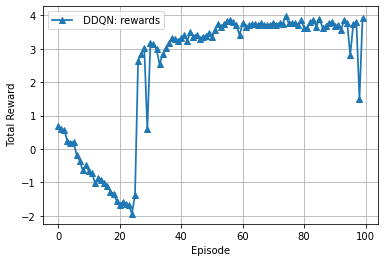

In [ ]:
aver_ddqn = []
step = (len(log_total_reward_ddqn)+1)/num_episodes
for i in range(0, len(log_total_reward_ddqn), int(step)):
  ddqn_eps_i = log_total_reward_ddqn[i:i+int(step)-1]
  aver_ddqn.append(np.mean(ddqn_eps_i))
  i += 1

plt.grid()
plt.plot(aver_ddqn, "^-", label=' DDQN: rewards', linewidth=1.75)
plt.xlabel("Episode")
plt.ylabel(" Total Reward")
plt.legend(loc = "best")
plt.show()

In [ ]:
step = len(log_total_reward_ddqn)/num_episodes
import os
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
save_path = now.strftime("%d_%m_%Y_%H_%M_%S")
model_path = "_DDQN_run.csv"
path = save_path + model_path
print(path)
episode = num_episodes 
num = int(step)*episode
with open(f'{path}','w') as f: 
    write = csv.writer(f) 
    for i in range(num):
         write.writerow([log_total_reward_ddqn[i], log_comp_reward_ddqn[i], log_cost_reward_ddqn[i], log_anten_reward_ddqn[i], log_connect_reward_ddqn[i]])

07_09_2022_14_24_25_DDQN_run.csv
